In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import pickle
from copy import copy
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import warnings
from collections import namedtuple
from itertools import product

from scipy.interpolate import RegularGridInterpolator, splev, splrep
from scipy.stats import chi2, norm
from scipy.optimize import fmin_l_bfgs_b
import seaborn as sns
from matplotlib.colors import LogNorm

from settings import poles, ngc1068, txs0506
from tools import get_mids, array_source_interp
from aeff_calculations import get_energy_psf_grid, calc_aeff_factor, get_aeff_and_binnings
from fluxes import (
    atmo_background,
    astro_flux,
    plot_spectrum,
    power_law,
    cut_off,
    parabola_index
)



Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# Settings

In [3]:
matplotlib = sns.mpl
plt = matplotlib.pyplot
warnings.filterwarnings("ignore")

def reset_mpl_settings():
    plt.style.use("../style.mplstyle")
    colorlist = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    return colorlist
colorlist = reset_mpl_settings()

contour_formats = {
    "IceCube": {"colors": [poles["IceCube"]["color"]], "linestyles": "--"},
    "Plenum-1": {"colors": [poles["Plenum-1"]["color"]], "linestyles": poles["Plenum-1"]["ls"]},
    "Plenum-2": {"colors": [poles["Plenum-2"]["color"]], "linestyles": poles["Plenum-2"]["ls"]},
}
e_smearing_files = sorted(glob("../resources/*energy_smearing_rgi.pckl"))
sigma5 = 1 - norm.cdf(5)
sigma3 = 1 - norm.cdf(3)
sigma1 = 1 - norm.cdf(1)

# helper functions

In [4]:
# interpolation function to find the discovery threshold using a pandas.DataFrame input
def get_scaler(x, thresh):
    return np.power(
        10,
        np.poly1d(np.polyfit(np.log10(x["log10(p)"]), np.log10(x["scaler"]), 1))(
            np.log10(-np.log10(thresh))
        ),
    )


In [5]:
def scaling_estimation(df, current_thresholds, scaler, nmax=20, min_steps=1, stop_here=0.1, stepper=1.5):
    r""" Estimate the best flux scaling factor to reach the current
    p-value threshold based on interpolating the recent tests with
    different scaling factors """

    # start with two values for the scaling factor
    if len(df) <= min_steps:
        scaler_new = scaler / stepper
        return scaler_new
        
    # check if we already sampled close enough to the threshold
    if abs(df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0])) < stop_here:
        # when we found one pval close to the threshold,
        # pick the next threshold
        _ = current_thresholds.pop(0)
        if len(current_thresholds) == 0:
            return -1
    
    # do the interpolation
    # pick the first threshold from the list
    scaler_new = get_scaler(df, current_thresholds[0])

    if scaler_new <= 0:
        # in case something went wrong
        # some random value to get started again
        print("scaling went wrong:", scaler_new)
        scaler_new = np.random.uniform(1.5, 3.5) / df.iloc[-1]["SosB"]

    # break the optimization loop once we reached nmax
    if len(df) == nmax:
        print(
            "Optimization failed! Diff is:",
            df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0]),
            "dec is:",
            dec,
            "thresh is:",
            current_thresholds[0],
        )
        _ = current_thresholds.pop(0)
    return scaler_new


# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [6]:
aeff_2d_base, logE_bins_old, _, sindec_bins_old, _ = get_aeff_and_binnings("upgoing")
logE_mids = get_mids(logE_bins_old)
sindec_mids = get_mids(sindec_bins_old)

# provide interpolation function for effective area
aeff_interp = {}
pad_logE = np.concatenate([[logE_bins_old[0]], logE_mids, [logE_bins_old[-1]]])
pad_sd = np.concatenate([[-1], sindec_mids, [1]])
for k in aeff_2d_base:
    aeff_interp[k] = RegularGridInterpolator(
        (pad_logE, pad_sd),
        np.pad(np.log(aeff_2d_base[k]), 1, mode="edge"),
    )

# set up new finer binning
logE_bins = np.linspace(2, 9, num=81)
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

sindec_bins = np.linspace(-1, 1, num=91)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")
# make a baseline evaluation of the interpolation
aeff_2d = {}
ss, ll = np.meshgrid(sindec_mids, logE_mids)
for k in aeff_2d_base:
    aeff_2d[k] = np.exp(aeff_interp[k]((ll, ss)))

80 log_10(energy) bins
90 declination bins


# Background

In [7]:
# MCEQ
with open("../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
# re-bin the atmospheric background flux
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_conv"])
)
# baseline evaluation
ss, em = np.meshgrid(sindec_mids, emids)
spl_vals = np.exp(rgi((em, ss)))


# Energy resolution function

Plotting code can be found in `energy_resolution.ipynb`

In [8]:
# energy smearing matrix
with open("../resources/energy_smearing_rgi.pckl", "rb") as f:
    rgi = pickle.load(f)
# new binning
logE_reco_bins = np.arange(1.9, 9.05, step=0.05)
logE_reco_mids = get_mids(logE_reco_bins)
lge_grid, lre_grid = np.meshgrid(logE_mids, logE_reco_mids)
# baseline evaluation
baseline_nkv = rgi((lre_grid, lge_grid))

# normalize per bin in true energy
baseline_nkv = baseline_nkv / np.sum(baseline_nkv, axis=0)

# artificial, improved smearing matrix
with open("../resources/improved_0.5_artificial_energy_smearing_rgi.pckl", "rb") as f:
    rgi = pickle.load(f)
improved_nkv = rgi((lre_grid, lge_grid))
# normalize per bin in true energy
improved_nkv = improved_nkv / np.sum(improved_nkv, axis=0)


# Flux definition

In [9]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

# NGC1068 and TXS 0506+056 - source parameters

In [10]:
# livetime of 10yr PS data
lt_10yr = (376.4 + 352.6 + 316.0 + 332.9 + 2198.2) * 24 * 3600
lt_kde = LIVETIME = 3186 * 24 * 3600
# LIVETIME = 10 * 360 * 24 * 3600 # 360 days of data taking per year

# 10yr PS PAPER PARAMETERS of NGC 1068
GAMMA_NGC = 3.2
PHI_NGC = 5E-14 # @ 1 TeV / GeV cm² s
E0_NGC = 1E3

# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt("../resources/ngc_paper_68_contour.txt")
phi_c_68 /= 1E11
#gamma_c_68, phi_c_68 = np.loadtxt("../resources/tenyr_paper_68_contour.txt")


# TXS parameters
with open("../resources/txs_contour.pkl", "rb") as f:
    txs_contour = pickle.load(f)

GAMMA_TXS = 2. #txs_contour["best-fit"][0]
PHI_TXS = 2.7E-20 #txs_contour["best-fit"][1] / 1E3 / 3 # fudge factor. # @ 1 TeV / GeV cm² s
E0_TXS = txs_contour["E0"] 

ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")
txs_flux = PL_flux(PHI_TXS, GAMMA_TXS, E0_TXS, "powerlaw")


In [11]:
# analysis region in distance to source
delta_psi_max = 2
ident = "IceCube"

ngc_src_config = dict(
    dec=ngc1068.dec.rad,
    sindec_mids=sindec_mids,
    livetime=LIVETIME,
    ewidth=ewidth,
)

txs_src_config = dict(
    dec=txs0506.dec.rad,
    sindec_mids=sindec_mids,
    livetime=LIVETIME,
    ewidth=ewidth,
)

# generic one without dec coordinate
src_config = dict(
    sindec_mids=sindec_mids,
    livetime=LIVETIME,
    ewidth=ewidth,
)


In [12]:
## check event numbers
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], dpsi_max=0, **ngc_src_config)
k_s = astro_flux(
    aeff_factor_signal,
    emids,
    baseline_nkv,
    1,
    ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~80

## check event numbers
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], dpsi_max=0, **txs_src_config)
k_s = astro_flux(
    aeff_factor_signal,
    emids,
    baseline_nkv,
    1,
    txs_flux,
)
print("txs 0506+056:", np.sum(k_s))  # ~5


ngc 1068: 83.5704046180578
txs 0506+056: 4.859902091824563


## PL+Cut: source parameters

In [13]:
# cutoff parameters
Gamma_cut = 2.0
logE_cut = 3.7 # log10 (Ecut / GeV)

tmp_flux = PLcut_flux(
    PHI_NGC, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
)


### scale the fluxes such that the event numbers match


In [14]:

## check event numbers
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], dpsi_max=0, **ngc_src_config)
astro_ev_sum_pl = np.sum(
    astro_flux(
        aeff_factor_signal,
        emids,
        baseline_nkv,
        1,
        ngc_flux,
    )
)

# cutoff
astro_ev_sum_cut = np.sum(
    astro_flux(
        aeff_factor_signal,
        emids,
        baseline_nkv,
        1,
        tmp_flux,
    )
)
flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut
print("flux_scaling_cut", flux_scaling_cut) ## should be ~0.97

# define the correctly normalized PL+cut flux for NGC 1068
ngc_cut_flux = PLcut_flux(
     PHI_NGC * flux_scaling_cut, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
)


flux_scaling_cut 0.974640874352507



### Plot flux and event expectation


powerlaw with cutoff 83.5704046180578
power law: 83.5704046180578


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


powerlaw with cutoff 83.57040461805778
power law: 83.57040461805781
powerlaw with cutoff 83.5704046180578
power law: 83.5704046180578


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


powerlaw with cutoff 83.57040461805778
power law: 83.57040461805781


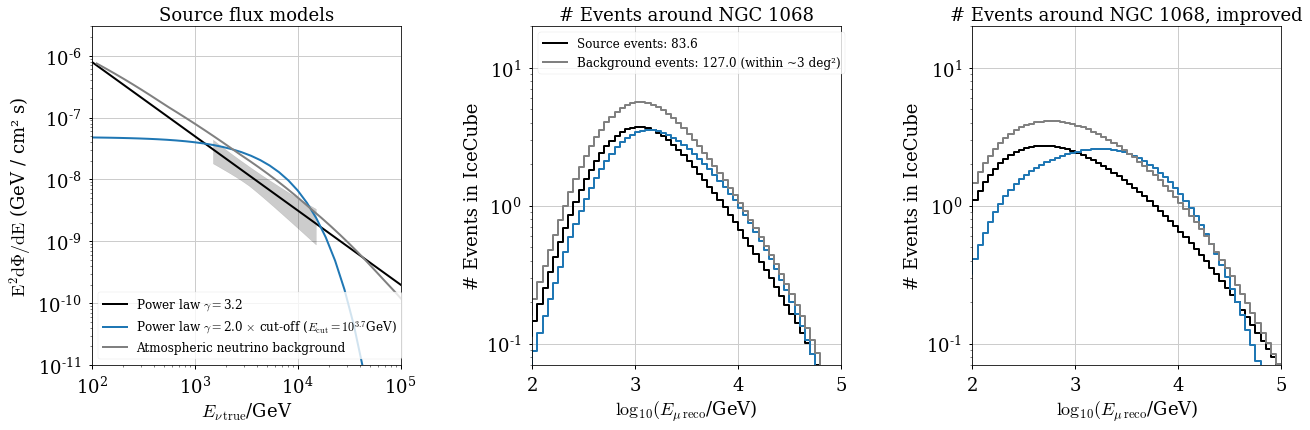

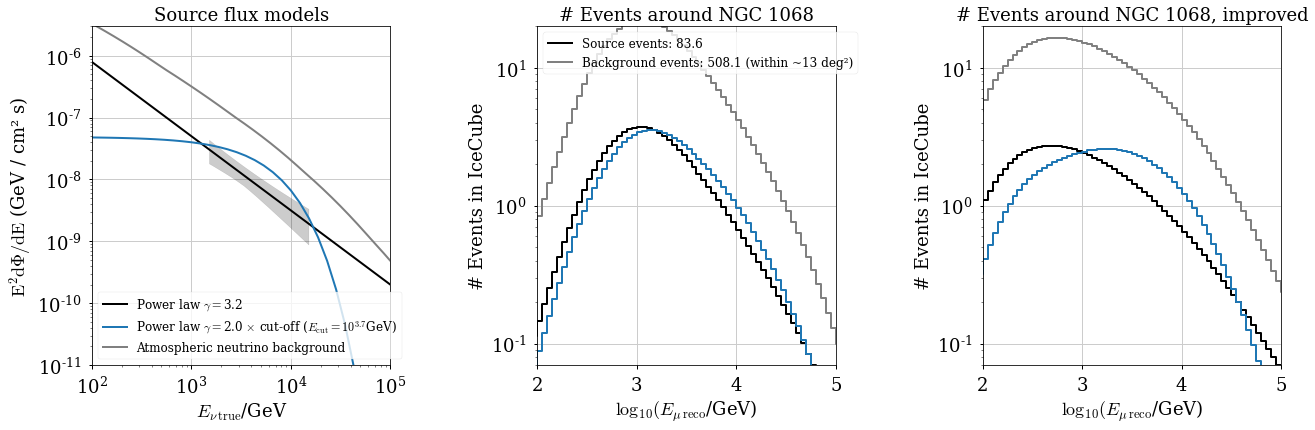

In [15]:
for delta_psi_max in [1, 2]:
    sq_deg = np.pi * delta_psi_max**2
    x_evals = np.logspace(0, 9, 100)
    y_scaling = 2

    pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)
    cut = power_law(
        x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
    ) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

    f, axes = plt.subplots(ncols=3, figsize=(18, 6))
    ax = axes[0]
    ax.set_title("Source flux models")

    # error contour
    # with energy range interval
    x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
    # without energy range interval
    # x_cont = np.logspace(1.9, 5.1, 100)
    c_low = np.zeros_like(x_cont)
    c_high = np.zeros_like(x_cont)
    for ii, xe in enumerate(x_cont):
        tmp = power_law(xe, ngc_flux.E0, gamma_c_68, phi_c_68 / 1e3)
        c_low[ii] = np.min(tmp)
        c_high[ii] = np.max(tmp)
    ax.fill_between(
        x_cont,
        c_low * (x_cont**y_scaling),
        c_high * (x_cont**y_scaling),
        color="k",
        alpha=0.2,
    )

    ax.plot(
        x_evals,
        pl * (x_evals**y_scaling),
        label=rf"Power law $\gamma=${ngc_flux.gamma}",
        color="k",
        alpha=1,
    )

    ax.plot(
        x_evals,
        cut * (x_evals**y_scaling),
        label=rf"Power law $\gamma=${ngc_cut_flux.gamma} $\times$ cut-off ($E_{{\rm cut}}=10^{{{ngc_cut_flux.e_cut:1.1f}}}$GeV)",
        color="tab:blue",
    )
    ax.plot(
        emids,
        array_source_interp(ngc1068.dec.rad, spl_vals, sindec_mids)
        * (np.deg2rad(delta_psi_max) ** 2)
        * np.pi
        * (emids**y_scaling),
        label="Atmospheric neutrino background",
        color="gray",
    )

    ax.set_yscale("log")
    ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)")
    ax.set_xscale("log")
    ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV")
    ax.set_ylim(1e-11, 3e-6)
    # ax.set_ylim(3e-6, 1e-3)
    ax.set_xlim(1e2, 1e5)
    ax.legend(loc=3, fontsize=12)

    ### plot Event numbers in E_reco
    for ii, (nkv, evals) in enumerate(
        zip([baseline_nkv, improved_nkv], [logE_reco_mids, logE_reco_mids])
    ):
        ax = axes[1 + ii]
        ident = "IceCube"
        aeff_factor_bckg = calc_aeff_factor(
            aeff_2d[ident], dpsi_max=delta_psi_max, **ngc_src_config
        )

        aeff_factor_signal = calc_aeff_factor(
            aeff_2d[ident], dpsi_max=0, **ngc_src_config
        )

        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(ngc_src_config["dec"], spl_vals, sindec_mids),
            normed_kvals=nkv,
        )

        # power law
        k_s_pl = astro_flux(
            aeff_factor_signal,
            emids,
            nkv,
            1,
            ngc_flux,
        )

        # cutoff
        k_s_cut = astro_flux(
            aeff_factor_signal,
            emids,
            nkv,
            1,
            ngc_cut_flux,
        )
        print("powerlaw with cutoff", np.sum(k_s_cut))
        print("power law:", np.sum(k_s_pl))

        _ = plot_spectrum(
            evals,
            [
                k_s_pl,
                k_s_cut,
                k_b,
            ],
            [
                f"Source events: {np.sum(k_s_pl):1.1f}" if ii == 0 else "",
                "",
                f"Background events: {np.sum(k_b):1.1f} (within ~{sq_deg:1.0f} deg²)"
                if ii == 0
                else "",
            ],
            "# Events around NGC 1068"
            if ii == 0
            else "# Events around NGC 1068, improved",
            f,
            ax,
            xlim=(2, 5),
            ylim=(7e-2, 2e1),
            color=["k", "tab:blue", "gray"],  # "darkred",
            xlabel=r"$\log_{10}(E_{\mu \, \rm reco}$/GeV)",
            ylabel="# Events in IceCube",
        )
        if ii == 1:
            ax.get_legend().remove()
        else:
            ax.legend(loc=2, fontsize=12)

    f.savefig(f"../plots/ngc_spectral_dpsi-{delta_psi_max}.pdf", bbox_inches="tight")
delta_psi_max = 2


## Parabola: source parameters

In [16]:
# parabola parameters
Alpha_TXS = 2
E_para_norm_TXS = 3E5
Beta_TXS = 1

tmp_flux = LogP_flux(
    PHI_TXS, Alpha_TXS, Beta_TXS, E_para_norm_TXS, "log-parabola"
)


### scale the fluxes such that the event numbers match


In [17]:
aeff_factor_signal = calc_aeff_factor(
    aeff_2d["IceCube"], dpsi_max=0, grid_2d=1, **txs_src_config
)
astro_ev_sum_pl = np.sum(
    astro_flux(
        aeff_factor_signal,
        emids,
        normed_kvals=baseline_nkv,
        phi_scaling=1,
        flux_shape=txs_flux
    )
)

# parabola
astro_ev_sum_para = np.sum(
    astro_flux(
        aeff_factor_signal,
        emids,
        normed_kvals=baseline_nkv,
        phi_scaling=1,
        flux_shape=tmp_flux
    )
)
# match event numbers
flux_scaling_para_txs = astro_ev_sum_pl / astro_ev_sum_para
print("flux_scaling_para", flux_scaling_para_txs)

# define the correctly normalized log-parabola flux for TXS
txs_para_flux = LogP_flux(
     flux_scaling_para_txs * PHI_TXS, Alpha_TXS, Beta_TXS, E_para_norm_TXS, "log-parabola"
)


flux_scaling_para 0.3523585844892015



### Plot flux and event expectation


parabola 4.859902091824563
power law: 4.859902091824563


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


parabola 4.859902091824562
power law: 4.859902091824563


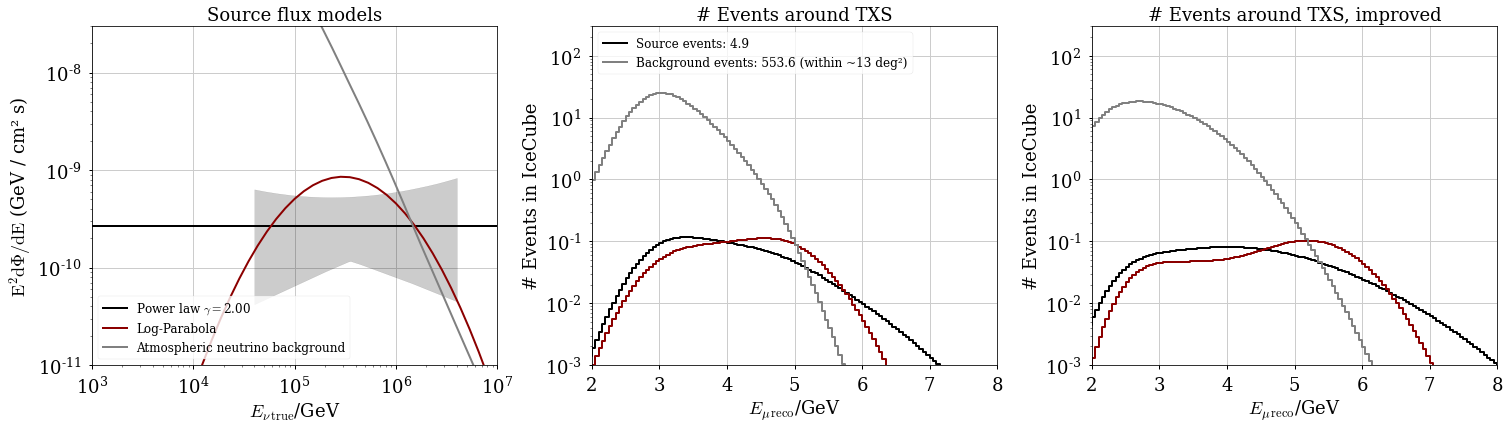

In [18]:
sq_deg = np.pi * delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

pl = power_law(x_evals, txs_flux.E0, txs_flux.gamma, txs_flux.norm)
para_idx = parabola_index(
    txs_para_flux.alpha, txs_para_flux.beta, x_evals, txs_para_flux.E0
)
para = power_law(x_evals, txs_para_flux.E0, para_idx, txs_para_flux.norm)

f, axes = plt.subplots(ncols=3, figsize=(21, 6))
ax = axes[0]
ax.set_title("Source flux models")

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(4e4), np.log10(4e6), 100)
# without energy range interval
# x_cont = np.logspace(3, 7, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(
        xe,
        txs_flux.E0,
        txs_contour["68\\%"][:, 0],
        txs_contour["68\\%"][:, 1] / 1e3 / 2.8,
    )  ## fudge factor :)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    color="k",
    alpha=0.2,
)


ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"Power law $\gamma=${txs_flux.gamma:1.2f}",
    color="k",
    alpha=1,
)
ax.plot(x_evals, para * (x_evals**y_scaling), label="Log-Parabola", color="darkred")
ax.plot(
    emids,
    array_source_interp(txs_src_config["dec"], spl_vals, sindec_mids) * (emids**y_scaling),
    label="Atmospheric neutrino background",
    color="gray",
)

ax.set_yscale("log")
ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)")
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV")
ax.set_ylim(1e-11, 3e-8)
ax.set_xlim(1e3, 1e7)
ax.legend(loc=3, fontsize=12)

### plot Event numbers in E_reco
for ii, nkv in enumerate([baseline_nkv, improved_nkv]):
    ax = axes[1 + ii]
    ident = "IceCube"
    aeff_factor_bckg = calc_aeff_factor(
        aeff_2d[ident], dpsi_max=delta_psi_max, **txs_src_config
    )
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], dpsi_max=0, **txs_src_config)

    use_e_reco = True
    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(txs0506.dec.rad, spl_vals, sindec_mids),
        normed_kvals=nkv,
    )

    # parabola
    k_s_para = astro_flux(
        aeff_factor_signal,
        emids,
        nkv,
        1,
        txs_para_flux,
    )
    print("parabola", np.sum(k_s_para))

    # powerlaw
    k_s_pl = astro_flux(
        aeff_factor_signal,
        emids,
        nkv,
        1,
        txs_flux,
    )
    print("power law:", np.sum(k_s_pl))

    evals = logE_reco_mids
    _ = plot_spectrum(
        evals,
        [
            k_s_pl,
            k_s_para,
            k_b,
        ],
        [
            f"Source events: {np.sum(k_s_pl):1.1f}" if ii == 0 else "",
            "",
            f"Background events: {np.sum(k_b):1.1f} (within ~{sq_deg:1.0f} deg²)"
            if ii == 0
            else "",
        ],
        "# Events around TXS" if ii == 0 else "# Events around TXS, improved",
        f,
        ax,
        xlim=(2, 8),
        ylim=(1e-3, 3e2),
        color=["k", "darkred", "gray"],
        xlabel=r"$E_{\mu \, \rm reco}$/GeV",
        ylabel="# Events in IceCube",
    )
    if ii == 1:
        ax.get_legend().remove()
    else:
        ax.legend(loc=2, fontsize=12)

f.savefig("../plots/txs_spectral.pdf", bbox_inches="tight")


# PSF-Energy grid from the smearing matrix
$f_x(x) = kde(x)$ with $ x = \log_{10}(y) \Leftrightarrow y = 10^x$

Transform: $z = y² = 10^{(2\cdot x)}$ with $ x = \frac{\log_{10}(z)}{2} := g(z)$

$\Rightarrow f_z(z) = | \frac{d}{dz} g(z) | \cdot f(g(z)) = \frac{1}{2\cdot z \cdot \log(10)} kde(\frac{\log_{10}(z)}{2})$



Full 2D psi-energy LLH of sources around the horizon

NOTE: psi changes per detector over the day. Not yet implemented, effect probably negligible. We choose the horizontal resolution for all detectors

In [19]:
# psi² representation
delta_psi_max = 2
bins_per_psi2 = 25
all_grids, psi2_bins = get_energy_psf_grid(
    logE_mids, delta_psi_max=delta_psi_max, bins_per_psi2=bins_per_psi2
)
psi2_mids = get_mids(psi2_bins)

e_psi2_grid = all_grids['dec-0.0']
bckg_grid = np.ones_like(e_psi2_grid)
bckg_grid /= np.sum(bckg_grid, axis=0)

file exists: ../resources/e_psf_grid_psimax-2_bins-25.pckl


## plotting

1D plots and 2D plots (= analysis histogram)

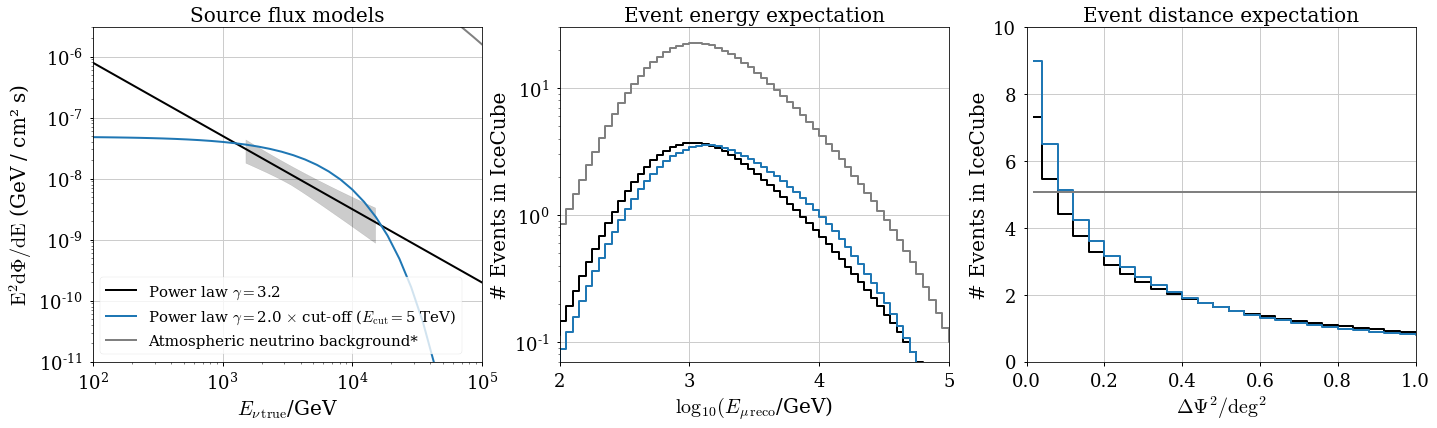

In [20]:
sq_deg = np.pi * delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)
cut = power_law(
    x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

f, axes = plt.subplots(ncols=3, figsize=(20, 6))
ax = axes[0]
fontsize = 20
ax.set_title("Source flux models", fontsize=fontsize)

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
# without energy range interval
# x_cont = np.logspace(1.9, 5.1, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, E0_NGC, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    color="k",
    alpha=0.2,
)

ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"Power law $\gamma=${GAMMA_NGC}",
    color="k",
    alpha=1,
)

ax.plot(
    x_evals,
    cut * (x_evals**y_scaling),
    label=rf"Power law $\gamma=${Gamma_cut} $\times$ cut-off ($E_{{\rm cut}}=${(10**logE_cut)/1E3:1.0f} TeV)",
    color="tab:blue",
)
ax.plot(
    emids,
    array_source_interp(ngc_src_config["dec"], spl_vals, sindec_mids)
    * sq_deg
    * (emids**y_scaling),
    label="Atmospheric neutrino background*",
    color="gray",
)

ax.set_yscale("log")
ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)", fontsize=fontsize)
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV", fontsize=fontsize)
ax.set_ylim(1e-11, 3e-6)
ax.set_xlim(1e2, 1e5)
ax.legend(loc=3, fontsize=fontsize - 5)


### plot Event numbers in E_reco
ii = 0
nkv = baseline_nkv
evals = logE_reco_mids
ax = axes[1]
ident = "IceCube"
aeff_factor_bckg = calc_aeff_factor(
    aeff_2d[ident], dpsi_max=delta_psi_max, grid_2d=bckg_grid, **ngc_src_config
)

aeff_factor_signal = calc_aeff_factor(
    aeff_2d[ident], dpsi_max=0, grid_2d=e_psi2_grid, **ngc_src_config
)

k_b = atmo_background(
    aeff_factor_bckg,
    array_source_interp(ngc_src_config["dec"], spl_vals, sindec_mids),
    normed_kvals=nkv,
)

# power law
k_s_pl = astro_flux(
    aeff_factor_signal,
    emids,
    nkv,
    1,
    ngc_flux,
)

# cutoff
k_s_cut = astro_flux(
    aeff_factor_signal,
    emids,
    nkv,
    1,
    ngc_cut_flux,
)

ax = axes[1]
ax.plot(
    evals,
    k_s_pl.sum(axis=0),
    drawstyle="steps-mid",
    label=f"Source events: {np.sum(k_s_pl):1.1f}",
    color="k",
)

ax.plot(
    evals,
    k_s_cut.sum(axis=0),
    drawstyle="steps-mid",
    color="tab:blue",
)

ax.plot(
    evals,
    k_b.sum(axis=0),
    drawstyle="steps-mid",
    label=f"Background events: {np.sum(k_b):1.1f} (within ~{sq_deg:1.0f} deg²)",
    color="gray",
)
ax.set_title("Event energy expectation", fontsize=fontsize)
ax.set_yscale("log")
ax.set_xlim(2, 5)
ax.set_ylim(7e-2, 3e1)
ax.set_xlabel(r"$\log_{10}(E_{\mu \, \rm reco}$/GeV)", fontsize=fontsize)
ax.set_ylabel("# Events in IceCube", fontsize=fontsize)
# ax.legend(loc=2, fontsize=fontsize)
ax.set_xticks([2, 3, 4, 5])

ax = axes[2]
ax.plot(
    psi2_mids,
    k_s_pl.sum(axis=1),
    drawstyle="steps-mid",
    color="k",
)

ax.plot(
    psi2_mids,
    k_s_cut.sum(axis=1),
    drawstyle="steps-mid",
    color="tab:blue",
)

ax.plot(
    psi2_mids,
    k_b.sum(axis=1),
    drawstyle="steps-mid",
    color="gray",
)
ax.set_ylabel("# Events in IceCube", fontsize=fontsize)
ax.set_xlim(0, 1)
ax.set_ylim(0, 10)
ax.set_xlabel(r"$\Delta \Psi ^2 / {\rm deg}^2$", fontsize=fontsize)
ax.set_title("Event distance expectation", fontsize=fontsize)
f.tight_layout()

plt.subplots_adjust(wspace=0.2)

f.savefig(f"../plots/ngc_spectral_dpsi.pdf", bbox_inches="tight")


Text(0.5, 0, 'log10(E/GeV)')

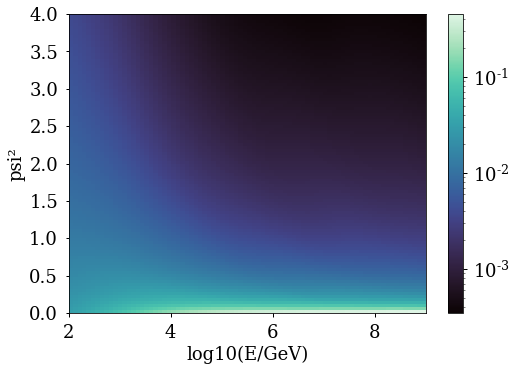

In [21]:
plt.figure()
plt.pcolormesh(logE_mids, psi2_mids, e_psi2_grid, norm=LogNorm())
plt.colorbar()
plt.ylabel("psi²")
plt.xlabel("log10(E/GeV)")

# Set up LLH function

In [22]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    normed_kvals,
    src_dec,
    verbose=False
):
    """fit parameters in x:
    for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2]: signal spectral index

    see 'astro_flux' for further shapes and parameters

    mu_b_base: effective area factor for background
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape
    """
    mu_b = atmo_background(
        mu_b_base * x[0],
        array_source_interp(src_dec, spl_vals, sindec_mids),
        normed_kvals=normed_kvals,
    )
    mu_s = astro_flux(
        mu_s_base,
        emids,
        normed_kvals,
        x[1],
        flux_collection[shape](phi_0, *x[2:], e_0, shape),
    )
    if verbose:
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))
    mu_i = mu_s + mu_b

    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


# NGC 1068
## Significance test Background vs. Background + Signal

In [23]:
ident = "IceCube"
print(ident)

aeff_factor_bckg = calc_aeff_factor(
    aeff_2d[ident], dpsi_max=delta_psi_max, grid_2d=bckg_grid, **ngc_src_config
)

aeff_factor_signal = calc_aeff_factor(
    aeff_2d[ident], dpsi_max=0, grid_2d=e_psi2_grid, **ngc_src_config
)

# asimov data
k_b = atmo_background(
    aeff_factor=aeff_factor_bckg,
    spl_vals=array_source_interp(ngc_src_config["dec"], spl_vals, sindec_mids),
    normed_kvals=baseline_nkv,
)
# power law
k_s = astro_flux(
    aeff_factor=aeff_factor_signal,
    emids=emids,
    normed_kvals=baseline_nkv,
    phi_scaling=1,
    flux_shape=ngc_flux, # powerlaw
)
k_i = k_s + k_b

print("Asimov data sum:")
print("Background:", np.sum(k_b))
print("Signal:", np.sum(k_s))


dct = dict(
    shape="powerlaw",
    mu_b_base=aeff_factor_bckg,
    mu_s_base=aeff_factor_signal,
    k_i=k_i,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    normed_kvals=baseline_nkv,
    src_dec=ngc1068.dec.rad,
)

# fix signal normalization to 0
local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
global_llh = lambda x: ps_llh_2d_composite(x, **dct)
out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1.2,),
    approx_grad=True,
)
print("Atmo-only normalization:", out_bckg[0])

out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1.2, 1.2, 3.0),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])
print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
significance = norm.isf(pval)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)


IceCube
Asimov data sum:
Background: 508.12721938513477
Signal: 83.57040461805781
Atmo-only normalization: [1.16447056]
Signal fit parameters: [0.99998885 0.9998927  3.19991436]
-2 Delta LLH: 18.75088287415565
P-VALUE: 8.478080159546436e-05 SIGNIFICANCE: 3.7605183973642555


## Significance test Background vs. Background + Signal with improved energy resolution

In [24]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
for ident in idents:
    print(ident)
    print("="*10)
    

    aeff_factor_bckg = calc_aeff_factor(
        aeff_2d[ident], dpsi_max=delta_psi_max, grid_2d=bckg_grid, **ngc_src_config
    )
    if "Plenum" in ident or "P-ONE" in ident:
        aeff_factor_bckg += calc_aeff_factor(
            aeff_2d["IceCube"],
            dpsi_max=delta_psi_max,
            grid_2d=bckg_grid,
            **ngc_src_config
        )

    aeff_factor_signal = calc_aeff_factor(
        aeff_2d[ident], dpsi_max=0, grid_2d=e_psi2_grid, **ngc_src_config
    )
    if "Plenum" in ident or "P-ONE" in ident:
        aeff_factor_signal += calc_aeff_factor(
            aeff_2d["IceCube"], dpsi_max=0, grid_2d=e_psi2_grid, **ngc_src_config
        )
    for ef in e_smearing_files:
        # energy smearing matrix
        with open(ef, "rb") as f:
            rgi = pickle.load(f)
        nkv = rgi((lre_grid, lge_grid))
        # normalize per bin in true energy
        nkv = nkv / np.sum(nkv, axis=0)
        es_ident = ef.split("/")[-1].split("_energy")[0]
        print(es_ident)
        print("- "*10)

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(ngc_src_config["dec"], spl_vals, sindec_mids),
            normed_kvals=nkv,
        )
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            normed_kvals=nkv,
            phi_scaling=1,
            flux_shape=ngc_flux, # powerlaw
        )
        k_i = k_s + k_b

        # define the fitting functions with all parameters
        # background only, 1 free parameter
        dct = dict(
            shape="powerlaw",
            mu_b_base=aeff_factor_bckg,
            mu_s_base=aeff_factor_signal,
            k_i=k_i,
            e_0=ngc_flux.E0,
            phi_0=ngc_flux.norm,
            normed_kvals=nkv,
            src_dec=ngc1068.dec.rad,
        )
        # fix signal contribution to 0
        local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
        global_llh = lambda x: ps_llh_2d_composite(x, **dct)
        # ... and fit both hypotheses!
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2,),
            approx_grad=True,
        )
        print("Atmo-only normalization:", out_bckg[0])

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 1.2, 3.0),
            approx_grad=True,
        )
        print("Signal fit parameters:", out_comp[0])
        # print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

        # calculate p-value and significance with Wilks'
        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        significance = norm.isf(pval)
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        print("")


IceCube
artificial
- - - - - - - - - - 
Atmo-only normalization: [1.16446741]
Signal fit parameters: [0.99999467 1.0000375  3.20003097]
P-VALUE: 9.171983397413151e-05 SIGNIFICANCE: 3.740794220128974

energy_smearing_rgi.pckl
- - - - - - - - - - 
Atmo-only normalization: [1.16447056]
Signal fit parameters: [0.99998885 0.9998927  3.19991436]
P-VALUE: 8.478080159546436e-05 SIGNIFICANCE: 3.7605183973642555

idealized_artificial
- - - - - - - - - - 
Atmo-only normalization: [1.16446757]
Signal fit parameters: [1.00002589 0.99999465 3.20011421]
P-VALUE: 7.007481067660746e-05 SIGNIFICANCE: 3.8079040625614797

improved_0.05_artificial
- - - - - - - - - - 
Atmo-only normalization: [1.16446692]
Signal fit parameters: [1.00001103 0.99995579 3.20003867]
P-VALUE: 6.8456690981605e-05 SIGNIFICANCE: 3.813678812464405

improved_0.1_artificial
- - - - - - - - - - 
Atmo-only normalization: [1.16446893]
Signal fit parameters: [1.00000514 0.99987974 3.19998003]
P-VALUE: 6.69580504442984e-05 SIGNIFICANCE: 3

## Disc. potential vs dec

In [25]:
thresholds = [sigma5]
# idents = ["IceCube"]
idents = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
decs = np.arange(-70, 71, step=5)

tmp = [] # save output here
for ident in idents:
    for dec in tqdm(np.deg2rad(decs)):
        if ident == "IceCube" and dec <= np.deg2rad(-5):
            # skip the Southern Hemisphere
            continue
        src_config["dec"] = dec
        aeff_factor_bckg = calc_aeff_factor(
            aeff_2d[ident], dpsi_max=delta_psi_max, grid_2d=bckg_grid, **src_config
        )
        if "Plenum" in ident or "P-ONE" in ident:
            aeff_factor_bckg += calc_aeff_factor(
                aeff_2d["IceCube"],
                dpsi_max=delta_psi_max,
                grid_2d=bckg_grid,
                **src_config
            )

        aeff_factor_signal = calc_aeff_factor(
            aeff_2d[ident], dpsi_max=0, grid_2d=e_psi2_grid, **src_config
        )
        if "Plenum" in ident or "P-ONE" in ident:
            aeff_factor_signal += calc_aeff_factor(
                aeff_2d["IceCube"], dpsi_max=0, grid_2d=e_psi2_grid, **src_config
            )

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(src_config["dec"], spl_vals, sindec_mids),
            normed_kvals=baseline_nkv,
        )
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            baseline_nkv,
            1,
            ngc_flux,  # powerlaw
        )
        # calculate an estimate for the flux scaling (black magic)
        scaler = 6 / (np.sum(k_s) / np.sqrt(np.sum(k_b)))
        current_thresholds = copy(thresholds)
        count = 0
        while len(current_thresholds) > 0:
            tmp_dct = {
                "ident": ident,
                "dec": dec,
                "scaler": scaler,
                "cur_thresh": current_thresholds[0],
            }

            k_s = astro_flux(
                aeff_factor_signal,
                emids,
                baseline_nkv,
                scaler,
                ngc_flux,  # powerlaw
            )
            k_i = k_s + k_b

            tmp_dct["SosB"] = np.sum(k_s) / np.sqrt(np.sum(k_b))
            tmp_dct["n_b"] = np.sum(k_b)
            tmp_dct["n_sig"] = np.sum(k_s)

            dct = dict(
                shape="powerlaw",
                mu_b_base=aeff_factor_bckg,
                mu_s_base=aeff_factor_signal,
                k_i=k_i,
                e_0=ngc_flux.E0,
                phi_0=ngc_flux.norm,
                normed_kvals=baseline_nkv,
                src_dec=dec,
            )
            # fix signal contribution to 0
            local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
            global_llh = lambda x: ps_llh_2d_composite(x, **dct)
            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2,),
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1.2, 1.2, 3.0),
                approx_grad=True,
            )

            tmp_dct["log10(p)"] = -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2))
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)
            mask = (
                (tmp_df.dec == dec)
                & (tmp_df.ident == ident)
                & (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
            )

            if scaler == -1:
                break

df = pd.DataFrame(tmp)
df.to_pickle("../resources/ngc_disc_pot.pickle")


100%|██████████| 29/29 [00:29<00:00,  1.00s/it]


In [26]:
df = pd.read_pickle("../resources/ngc_disc_pot.pickle")

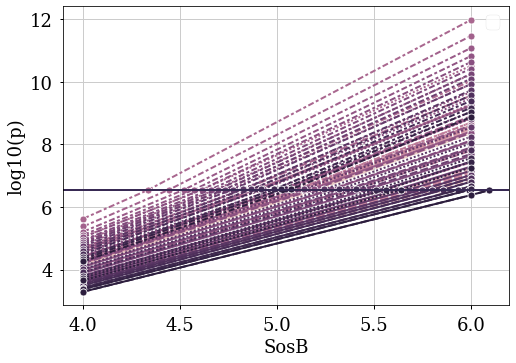

In [27]:
df = pd.DataFrame(tmp)
ax = sns.lineplot(
    data=df, y="log10(p)", x="SosB", hue="dec", marker="o", style="ident"
)
ax.legend([])
for t in thresholds:
    plt.axhline(-np.log10(t))
# plt.ylim(6, 7)
# plt.xlim(4.5, 6)


In [28]:
from settings import poles

# adjust labels
poles["IceCube"]["label"] = "IceCube (10yr)"
poles["P-ONE"]["label"] = "+ P-ONE (10yr)"
poles["Plenum-1"]["label"] = "+ Plenum-1 (10yr)"
poles["Plenum-2"]["label"] = "+ Plenum-2 (10yr)"


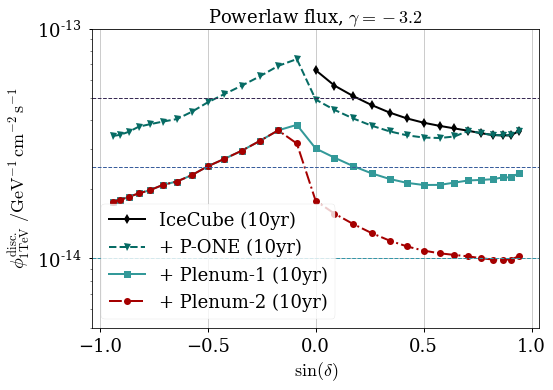

In [29]:
flux = pd.DataFrame(
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma5)) * PHI_NGC,
    columns=["disc5"],
).reset_index()

f, ax = plt.subplots()
for ident, series in flux.groupby(["ident"]):
    plt.plot(
        np.sin(series.dec),
        series.disc5,
        **{k: poles[ident][k] for k in ["marker", "ls", "color", "label"]}
    )
ax.set_yscale("log")
ax.axhline(PHI_NGC, ls="--", lw=1, color=colorlist[0])  # , label="NGC 1068 flux")
ax.axhline(
    PHI_NGC / 2, ls="--", lw=1, color=colorlist[1]
)  # , label="NGC 1068 flux / 2")
ax.axhline(
    PHI_NGC / 5, ls="--", lw=1, color=colorlist[2]
)  # , label="NGC 1068 flux / 5")

ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
ax.legend()
ax.set_title(r"Powerlaw flux, $\gamma=-3.2$")
ax.set_ylim(0.5e-14, 1e-13)
f.savefig("../plots/ngc_disc_pot.pdf", bbox_inches="tight")


## cross check with gamma=-3 


In [30]:
idents = ["IceCube"]
decs = np.arange(-70, 71, step=5)
gamma3_flux = PL_flux(PHI_NGC, 3.0, E0_NGC, "powerlaw")
tmp = []
num = 25
thresholds = [sigma5]

for ident in idents:
    for dec in tqdm(np.deg2rad(decs)):
        if ident == "IceCube" and dec <= np.deg2rad(-5):
            # skip the Southern Hemisphere
            continue
        src_config["dec"] = dec
        aeff_factor_bckg = calc_aeff_factor(
            aeff_2d[ident], dpsi_max=delta_psi_max, grid_2d=bckg_grid, **src_config
        )
        if "Plenum" in ident or "P-ONE" in ident:
            aeff_factor_bckg += calc_aeff_factor(
                aeff_2d["IceCube"],
                dpsi_max=delta_psi_max,
                grid_2d=bckg_grid,
                **src_config
            )

        aeff_factor_signal = calc_aeff_factor(
            aeff_2d[ident], dpsi_max=0, grid_2d=e_psi2_grid, **src_config
        )
        if "Plenum" in ident or "P-ONE" in ident:
            aeff_factor_signal += calc_aeff_factor(
                aeff_2d["IceCube"], dpsi_max=0, grid_2d=e_psi2_grid, **src_config
            )

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(src_config["dec"], spl_vals, sindec_mids),
            normed_kvals=baseline_nkv,
        )
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            baseline_nkv,
            1,
            gamma3_flux,  # powerlaw
        )
        # calculate an estimate for the flux scaling
        scaler = 6 / (np.sum(k_s) / np.sqrt(np.sum(k_b)))
        current_thresholds = copy(thresholds)
        while len(current_thresholds) > 0:
            tmp_dct = {
                "ident": ident,
                "dec": src_config["dec"],
                "scaler": scaler,
                "cur_thresh": current_thresholds[0],
            }

            k_s = astro_flux(
                aeff_factor_signal,
                emids,
                baseline_nkv,
                scaler,
                gamma3_flux,  # powerlaw
            )
            k_i = k_s + k_b

            tmp_dct["SosB"] = np.sum(k_s) / np.sqrt(np.sum(k_b))
            tmp_dct["n_b"] = np.sum(k_b)
            tmp_dct["n_sig"] = np.sum(k_s)

            dct = dict(
                shape="powerlaw",
                mu_b_base=aeff_factor_bckg,
                mu_s_base=aeff_factor_signal,
                k_i=k_i,
                e_0=gamma3_flux.E0,
                phi_0=gamma3_flux.norm,
                normed_kvals=baseline_nkv,
                src_dec=dec,
            )
            # fix signal contribution to 0
            local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
            global_llh = lambda x: ps_llh_2d_composite(x, **dct)
            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2,),
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1.2, 1.2, 3.0),
                approx_grad=True,
            )

            tmp_dct["log10(p)"] = -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2))
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)

            mask = (
                (tmp_df.dec == dec)
                & (tmp_df.ident == ident)
                & (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
            )

            if scaler == -1:
                break

df = pd.DataFrame(tmp)
df.to_pickle("../resources/gamma3_disc_pot.pickle")


100%|██████████| 29/29 [00:08<00:00,  3.40it/s]


In [31]:
# comparison data from 10yr paper
ps_disc = dict()
ind_disc = dict()
xsd = dict()
ic_10yr = dict()
spl_10yr = dict()

gamma = 3.0
ps_disc[gamma] = np.genfromtxt('../resources/10yr_ps_dicPot_g3_tessaThesis.csv', delimiter=',')

for gamma in ps_disc:
    ind_disc[gamma] = np.argsort(ps_disc[gamma][:,0])
    xsd[gamma] = ps_disc[gamma][:,0][ind_disc[gamma] ]
    ic_10yr[gamma] = ps_disc[gamma][:,1][ind_disc[gamma] ]
    spl_10yr[gamma] = splrep(xsd[gamma], ic_10yr[gamma])

In [32]:
flux = pd.DataFrame(
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma5))
    * gamma3_flux.norm,
    columns=["disc5"],
).reset_index()


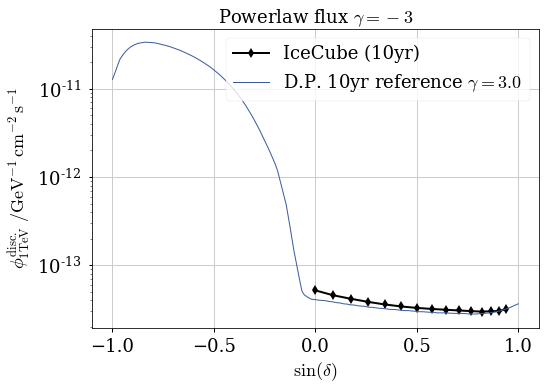

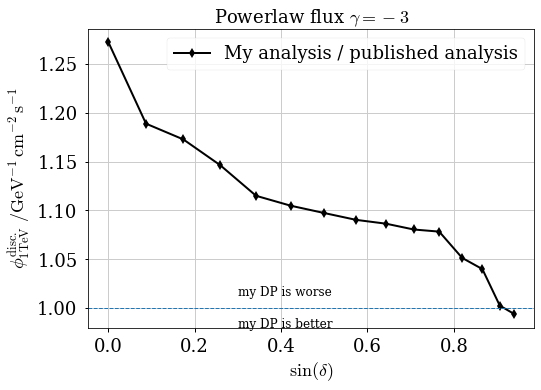

In [33]:
gamma = 3.0
ident = "IceCube"

f, ax = plt.subplots()
for ident, series in flux.groupby(["ident"]):
    plt.plot(
        np.sin(series.dec),
        series.disc5,
        **{k: poles[ident][k] for k in ["marker", "ls", "color", "label"]}
    )

ax.plot(xsd[gamma], ic_10yr[gamma] / 1E3, lw=1, color=colorlist[1], label=fr'D.P. 10yr reference $\gamma={gamma}$')

ax.legend()
ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$")
#ax.set_ylim(0.5E-14, 1E-13)
ax.set_yscale("log")
ax.set_title(r"Powerlaw flux $\gamma=-3$")
f.savefig("../plots/gamma3_disc_pot.pdf", bbox_inches="tight")

f, ax = plt.subplots()
series = flux.loc[flux.ident==ident]

plt.plot(
    np.sin(series.dec),
    series.disc5 / splev(np.sin(series.dec), spl_10yr[gamma]) * 1E3,
    **{k: poles[ident][k] for k in ["marker", "ls", "color"]},
    label="My analysis / published analysis"
)
plt.axhline(1, ls="--", lw=1, color="tab:blue")
plt.text(0.3, 0.99, "my DP is better", va="top", fontsize=12)
plt.text(0.3, 1.01, "my DP is worse", va="bottom", fontsize=12)
ax.legend()
ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$")
ax.set_title(r"Powerlaw flux $\gamma=-3$")
f.savefig("../plots/gamma3_disc_pot_ratio.pdf", bbox_inches="tight")


## Power law vs. Power-law with cutoff
### normal vs. improved E resolution

In [34]:
# livetime relative to 10yrs
detector_configurations = [
{"key":  "IceCube", "identifier": "10y IC", "e_file": '../resources/artificial_energy_smearing_rgi.pckl', "E_res": "Baseline"},
{"key":  "IceCube", "identifier": "10y IC", "e_file": '../resources/idealized_artificial_energy_smearing_rgi.pckl', "E_res": "Removed bias"},
{"key":  "IceCube", "identifier": "10y IC", "e_file": '../resources/improved_0.2_artificial_energy_smearing_rgi.pckl', "E_res": "20% improv."},
{"key":  "IceCube", "identifier": "10y IC", "e_file": '../resources/improved_0.5_artificial_energy_smearing_rgi.pckl', "E_res": "50% improv."},
{"key":    "P-ONE", "identifier": "10y IC + 10yr P-ONE", "e_file": '../resources/artificial_energy_smearing_rgi.pckl', "E_res": "Baseline"},
{"key":    "P-ONE", "identifier": "10y IC + 10yr P-ONE", "e_file": '../resources/idealized_artificial_energy_smearing_rgi.pckl', "E_res": "Removed bias"},
{"key":    "P-ONE", "identifier": "10y IC + 10yr P-ONE", "e_file": '../resources/improved_0.2_artificial_energy_smearing_rgi.pckl', "E_res": "20% improv."},
{"key":    "P-ONE", "identifier": "10y IC + 10yr P-ONE", "e_file": '../resources/improved_0.5_artificial_energy_smearing_rgi.pckl', "E_res": "50% improv."},
{"key": "Plenum-1", "identifier": "10y IC + 10y PL-1", "e_file": '../resources/artificial_energy_smearing_rgi.pckl', "E_res": "Baseline"},
{"key": "Plenum-1", "identifier": "10y IC + 10y PL-1", "e_file": '../resources/idealized_artificial_energy_smearing_rgi.pckl', "E_res": "Removed bias"},
{"key": "Plenum-1", "identifier": "10y IC + 10y PL-1", "e_file": '../resources/improved_0.2_artificial_energy_smearing_rgi.pckl', "E_res": "20% improv."},
{"key": "Plenum-1", "identifier": "10y IC + 10y PL-1", "e_file": '../resources/improved_0.5_artificial_energy_smearing_rgi.pckl', "E_res": "50% improv."},
{"key": "Plenum-2", "identifier": "10y IC + 10y PL-2", "e_file": '../resources/artificial_energy_smearing_rgi.pckl', "E_res": "Baseline"},
{"key": "Plenum-2", "identifier": "10y IC + 10y PL-2", "e_file": '../resources/idealized_artificial_energy_smearing_rgi.pckl', "E_res": "Removed bias"},
{"key": "Plenum-2", "identifier": "10y IC + 10y PL-2", "e_file": '../resources/improved_0.2_artificial_energy_smearing_rgi.pckl', "E_res": "20% improv."},
{"key": "Plenum-2", "identifier": "10y IC + 10y PL-2", "e_file": '../resources/improved_0.5_artificial_energy_smearing_rgi.pckl', "E_res": "50% improv."},
]

detector_configurations = pd.DataFrame(detector_configurations)

### Significance

In [35]:
pvals_ngc = []
for (identifier, es_ident), series in detector_configurations.groupby(
    ["identifier", "E_res"], sort=False
):
    print(es_ident, identifier)
    aeff_factor_bckg = calc_aeff_factor(
        aeff_2d[series.key.iloc[0]], dpsi_max=delta_psi_max, grid_2d=bckg_grid, **ngc_src_config
    )
    aeff_factor_signal = calc_aeff_factor(
        aeff_2d[series.key.iloc[0]], dpsi_max=0, grid_2d=e_psi2_grid, **ngc_src_config
    )
    ## add the other detector configs to IceCube
    if series.key.iloc[0] != "IceCube":
        aeff_factor_bckg += calc_aeff_factor(
            aeff_2d["IceCube"],
            dpsi_max=delta_psi_max,
            grid_2d=bckg_grid,
            **ngc_src_config
        )
        aeff_factor_signal += calc_aeff_factor(
            aeff_2d["IceCube"], dpsi_max=0, grid_2d=e_psi2_grid, **ngc_src_config
        )

    print(series.e_file.iloc[0])
    # energy smearing matrix
    with open(series.e_file.iloc[0], "rb") as f:
        rgi = pickle.load(f)
    nkv = rgi((lre_grid, lge_grid))
    # normalize per bin in true energy
    nkv = nkv / np.sum(nkv, axis=0)
    
    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(ngc_src_config["dec"], spl_vals, sindec_mids),
        normed_kvals=nkv,
    )
    k_s = astro_flux(
        aeff_factor_signal,
        emids,
        nkv,
        1,
        ngc_cut_flux, # powerlaw with cutoff
    )
    k_i = k_s + k_b

    if ii == 0:
        print(
            "Asimov data sum: Background =", np.sum(k_b), ", Signal =", np.sum(k_s)
        )
    dct = dict(
        mu_b_base=aeff_factor_bckg,
        mu_s_base=aeff_factor_signal,
        k_i=k_i,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
        normed_kvals=nkv,
        src_dec=ngc1068.dec.rad,
    )
    pl_func = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
    out_bckg = fmin_l_bfgs_b(
        pl_func,
        x0=(1.2, 1.2, 3.0),
        approx_grad=True,
    )
    print("bckg params:", out_bckg[0])

    comp = lambda x: ps_llh_2d_composite(x, shape="powerlaw with cutoff", **dct)
    out_comp = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 1.1, 1.9, 3.4),
        approx_grad=True,
    )
    print("global params:", out_comp[0])
    print("true params:", (1, flux_scaling_cut, Gamma_cut, logE_cut))

    # check the LLH at the "correct" parameter position
    check = comp((1, flux_scaling_cut, Gamma_cut, logE_cut))
    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    pval_check = chi2.sf(out_bckg[1] - check, 1)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print("pval check:", pval_check, "ratio:", pval_check / pval)
    print("")
    pvals_ngc.append(
        {
            "identifier": identifier,
            "key": series.key.iloc[0],
            "e_smearing": es_ident,
            "pval": pval,
            r"Significance in $\sigma$": significance,
        }
    )
pvals_ngc = pd.DataFrame(pvals_ngc)
pvals_ngc.to_pickle("../resources/ngc_performance_cut_eres.pickle")

Baseline 10y IC
../resources/artificial_energy_smearing_rgi.pckl
Asimov data sum: Background = 508.1272193851347 , Signal = 83.5704046180578
bckg params: [0.97602454 1.13722209 3.1739568 ]
global params: [0.99633748 1.14485868 1.84369398 3.55978225]
true params: (1, 0.974640874352507, 2.0, 3.7)
P-VALUE: 0.4724995659928546 SIGNIFICANCE: 0.06898804945878786
pval check: 0.4637086432633266 ratio: 0.9813948554406483

Removed bias 10y IC
../resources/idealized_artificial_energy_smearing_rgi.pckl
Asimov data sum: Background = 508.12721938513477 , Signal = 83.57040461805778
bckg params: [0.98840938 0.9904714  3.02254096]
global params: [1.00174567 0.96389769 1.84537125 3.62479078]
true params: (1, 0.974640874352507, 2.0, 3.7)
P-VALUE: 0.1650807961728437 SIGNIFICANCE: 0.9737884434214532
pval check: 0.164290090709861 ratio: 0.9952101911226863

20% improv. 10y IC
../resources/improved_0.2_artificial_energy_smearing_rgi.pckl
Asimov data sum: Background = 508.1272193851349 , Signal = 83.57040461805

### Nice significance summary plot

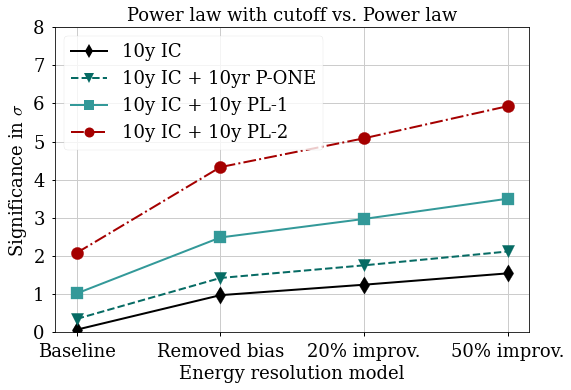

In [36]:
pval_df = pd.read_pickle("../resources/ngc_performance_cut_eres.pickle")
f, ax = plt.subplots()
label_size = "x-small"
for ident, series in pval_df.groupby(["key"]):
    series
    ax.plot(
        series["e_smearing"],
        series[r"Significance in $\sigma$"],
        ls=poles[ident]["ls"],
        color=poles[ident]["color"],
        marker=poles[ident]["marker"],
        label=series.identifier.iloc[0],
        ms=10,
    )
    ax.scatter(
        x=series["e_smearing"],
        y=series[r"Significance in $\sigma$"],
        c=[poles[ident]["color"]],
        s=150,
        zorder=10,
        marker=poles[ident]["marker"],
    )

ax.set_ylim(0, 8)
ax.legend(loc=2)
ax.set_title("Power law with cutoff vs. Power law", fontsize=18)
ax.set_xlabel("Energy resolution model", fontsize=18)
ax.set_ylabel(r"Significance in $\sigma$", fontsize=18)
f.tight_layout()
f.savefig("../plots/cutoff_sigma_vs_eres_ngc.pdf")


## spectral fit vs. dec

scan for right threshold

In [37]:
df = pd.read_pickle("../resources/ngc_spectral_disc_pot.pickle")

In [38]:
idents = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
decs = np.arange(-70, 71, step=5)
num = 20

thresholds = [sigma3, 0.01, 0.1]
tmp = []
for ident in idents:
    for dec in tqdm(np.deg2rad(decs)):
        if ident == "IceCube" and dec <= np.deg2rad(-5):
            # skip the Southern Hemisphere
            continue
        src_config["dec"] = dec
        aeff_factor_bckg = calc_aeff_factor(
            aeff_2d[ident], dpsi_max=delta_psi_max, grid_2d=bckg_grid, **src_config
        )

        aeff_factor_signal = calc_aeff_factor(
            aeff_2d[ident], dpsi_max=0, grid_2d=e_psi2_grid, **src_config
        )
        if "Plenum" in ident or "P-ONE" in ident:
            aeff_factor_bckg += calc_aeff_factor(
                aeff_2d["IceCube"],
                dpsi_max=delta_psi_max,
                grid_2d=bckg_grid,
                **src_config
            )

            aeff_factor_signal += calc_aeff_factor(
                aeff_2d["IceCube"], dpsi_max=0, grid_2d=e_psi2_grid, **src_config
            )

        # asimov data
        # improved energy resolution
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(src_config["dec"], spl_vals, sindec_mids),
            normed_kvals=improved_nkv,
        )
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            normed_kvals=improved_nkv,
            phi_scaling=1,
            flux_shape=ngc_cut_flux,
        )
        # calculate an estimate for the flux scaling
        scaler = 8 / (np.sum(k_s) / np.sqrt(np.sum(k_b)))
        current_thresholds = copy(thresholds)
        count = 0
        while len(current_thresholds) > 0:
            tmp_dct = {
                "ident": ident,
                "dec": dec,
                "scaler": scaler,
                "cur_thresh": current_thresholds[0],
            }
            k_s = astro_flux(
                aeff_factor_signal,
                emids,
                normed_kvals=improved_nkv,
                phi_scaling=scaler,
                flux_shape=ngc_cut_flux,
            )
            k_i = k_s + k_b
            tmp_dct["SosB"] = np.sum(k_s) / np.sqrt(np.sum(k_b))
            tmp_dct["n_sig"] = np.sum(k_s)

            dct = dict(
                mu_b_base=aeff_factor_bckg,
                mu_s_base=aeff_factor_signal,
                k_i=k_i,
                e_0=ngc_flux.E0,
                phi_0=PHI_NGC,
                normed_kvals=improved_nkv,
                src_dec=dec,
            )
            # fix signal contribution to powerlaw
            local_llh = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
            global_llh = lambda x: ps_llh_2d_composite(
                x, shape="powerlaw with cutoff", **dct
            )
            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2, 1.2, GAMMA_NGC),
                bounds=[(0, 10), (0, 10), (1, 5)],
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1.2, flux_scaling_cut * scaler, Gamma_cut, logE_cut),
                approx_grad=True,
            )
            tmp_dct["out_bg"] = out_bckg
            tmp_dct["out_comp"] = out_comp
            tmp_dct["log10(p)"] = -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 1))
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)
            mask = (
                (tmp_df.dec == dec)
                & (tmp_df.ident == ident)
                & (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask],
                current_thresholds,
                scaler,
                stop_here=0.2,
                stepper=2,
                min_steps=1,
            )

            if scaler == -1:
                break

df = pd.DataFrame(tmp)
df.to_pickle("../resources/ngc_spectral_disc_pot.pickle")


100%|██████████| 29/29 [01:24<00:00,  2.92s/it]


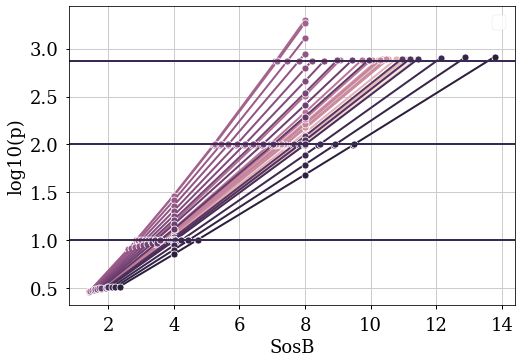

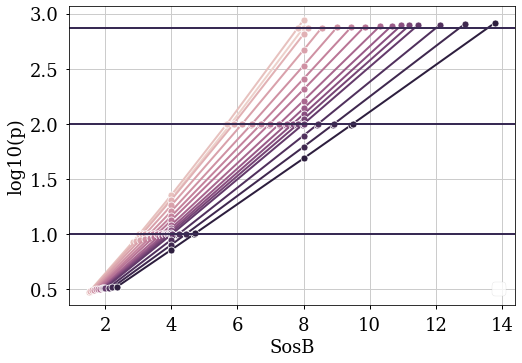

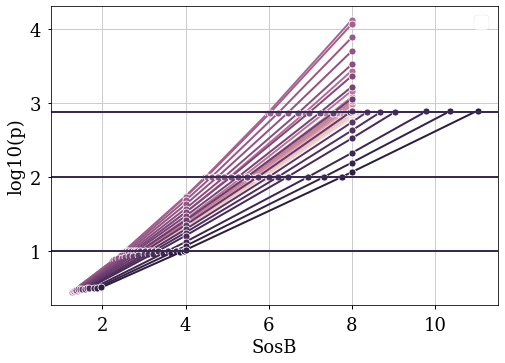

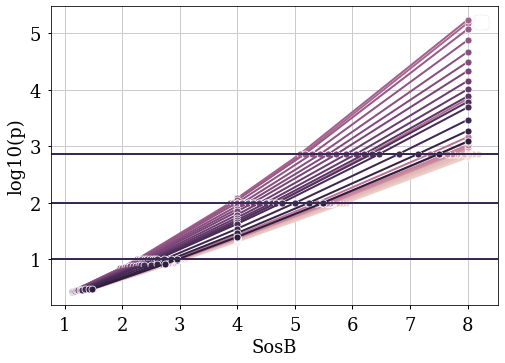

In [39]:
#df = pd.read_pickle("../resources/ngc_spectral_disc_pot.pickle")
thresholds = [sigma3, 0.01, 0.1]
xname = "SosB" # "scaler" # 
for ident in idents:
    plt.figure()
    ax = sns.lineplot(
        data=df.loc[df.ident == ident], y="log10(p)", x=xname, hue="dec", marker="o"
    )
    ax.legend([])
    for t in thresholds:
        plt.axhline(-np.log10(t))


In [40]:
flux = pd.DataFrame(df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma3)) * PHI_NGC, columns=["sigma3"])
flux["1%"] = df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.01)) * PHI_NGC
flux["10%"] = df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.1)) * PHI_NGC
flux = flux.reset_index()

from settings import poles
# adjust labels
poles["IceCube"]["label"] = "IceCube (10yr)"
poles["P-ONE"]["label"] = "IceCube + P-ONE (10yr)"
poles["Plenum-1"]["label"] = "IceCube + Plenum-1 (10yr)"
poles["Plenum-2"]["label"] = "IceCube + Plenum-2 (10yr)"


## plotting
### plot one threshold

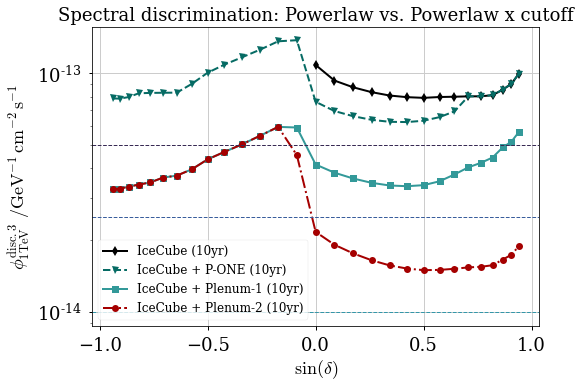

In [41]:
f, ax = plt.subplots()
for ident, series in flux.groupby(["ident"]):
    ax.plot(
        np.sin(series.dec),
        series.sigma3,
        #ls="-",
        **{k: poles[ident][k] for k in ["marker", "color", "ls", "label"]}
    )
ax.set_yscale("log")
ax.axhline(PHI_NGC, ls="--", lw=1, color=colorlist[0])
ax.axhline(PHI_NGC / 2, ls="--", lw=1, color=colorlist[1])
ax.axhline(PHI_NGC / 5, ls="--", lw=1, color=colorlist[2])
ax.set_xlabel(r"$\sin(\delta)$")
ax.legend(loc=0, fontsize=12)
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.3}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
ax.set_title(r"Spectral discrimination: Powerlaw vs. Powerlaw x cutoff")
f.savefig("../plots/ngc_spectral_3disc_pot.pdf", bbox_inches="tight")


### plot various thresholds

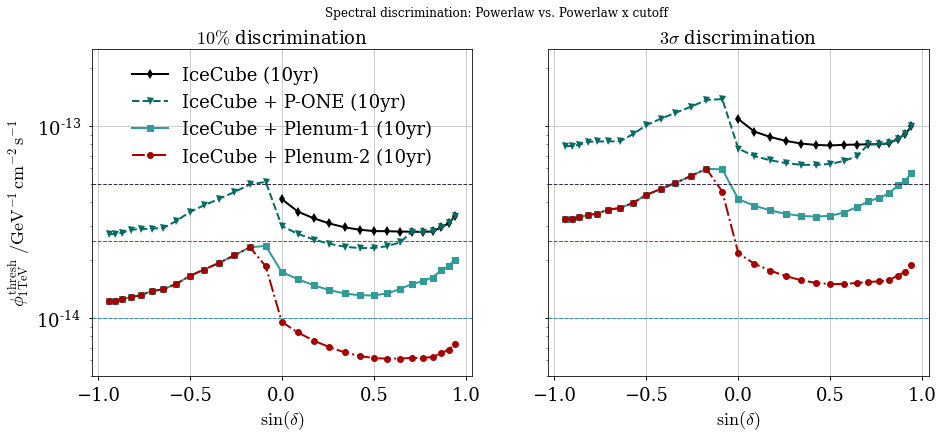

In [42]:
f, axes = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)
for ident, series in flux.groupby(["ident"]):
    axes[1].plot(
        np.sin(series.dec),
        series.sigma3,
        #ls="-",
        **{k: poles[ident][k] for k in ["marker", "color", "ls"]}
    )
    axes[0].plot(
        np.sin(series.dec),
        series["10%"],
        #ls=":",
        **{k: poles[ident][k] for k in ["marker", "color", "label", "ls"]}
    )
for ax in axes:
    ax.set_yscale("log")
    ax.axhline(PHI_NGC, ls="--", lw=1, color=colorlist[0])
    ax.axhline(PHI_NGC / 2, ls="--", lw=1, color=colorlist[1])
    ax.axhline(PHI_NGC / 5, ls="--", lw=1, color=colorlist[2])
    ax.set_xlabel(r"$\sin(\delta)$")
    ax.set_ylim(0.5e-14, 2.5e-13)
axes[0].legend(loc="upper center", frameon=False)
axes[0].set_title(r"$10\%$ discrimination")
axes[1].set_title(r"$3 \sigma$ discrimination")
axes[0].set_ylabel(
    r"$\phi^{\mathrm{thresh}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
f.suptitle(r"Spectral discrimination: Powerlaw vs. Powerlaw x cutoff")
f.savefig("../plots/ngc_spectral_disc_pot.pdf", bbox_inches="tight")


# TXS 0506+056


## spectral fit vs. dec

In [43]:
num = 20  # number of scaling steps
# idents = ["IceCube"] # for testing
# decs = np.arange(5, 60, step=15)
idents = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
decs = np.arange(-70, 71, step=5)
thresholds = [sigma3, 0.01]

for reduced_bg in [True, False]:
    print("reduced bg:", reduced_bg)
    tmp = []
    for ident in idents:
        for dec in tqdm(np.deg2rad(decs)):
            if ident == "IceCube" and dec <= np.deg2rad(-5):
                # skip the Southern Hemisphere
                continue
            # set current declination value
            src_config["dec"] = dec

            aeff_factor_bckg = calc_aeff_factor(
                aeff_2d[ident], dpsi_max=delta_psi_max, grid_2d=bckg_grid, **src_config
            )
            aeff_factor_signal = calc_aeff_factor(
                aeff_2d[ident], dpsi_max=0, grid_2d=e_psi2_grid, **src_config
            )
            if "Plenum" in ident or "P-ONE" in ident:
                aeff_factor_bckg += calc_aeff_factor(
                    aeff_2d["IceCube"],
                    dpsi_max=delta_psi_max,
                    grid_2d=bckg_grid,
                    **src_config
                )

                aeff_factor_signal += calc_aeff_factor(
                    aeff_2d["IceCube"], dpsi_max=0, grid_2d=e_psi2_grid, **src_config
                )
            # this means that the signal emission happens over 100 days
            # instead of full livetime
            if reduced_bg:
                aeff_factor_bckg = aeff_factor_bckg / LIVETIME * (100 * 24 * 3600)

            # asimov data - baseline
            k_b = atmo_background(
                aeff_factor_bckg,
                array_source_interp(src_config["dec"], spl_vals, sindec_mids),
                normed_kvals=improved_nkv,
            )
            k_s = astro_flux(
                aeff_factor_signal,
                emids,
                normed_kvals=improved_nkv,
                phi_scaling=1,
                flux_shape=txs_para_flux,
            )

            # calculate an estimate for the flux scaling
            # black magic
            if reduced_bg:
                scaler = 10 / np.sum(k_s) * np.sqrt(np.sum(k_b))
            else:
                scaler = 2.5 / np.sum(k_s) * np.sqrt(np.sum(k_b))

            current_thresholds = copy(thresholds)
            while len(current_thresholds) > 0:
                # model expectation for fitting
                k_s = astro_flux(
                    aeff_factor_signal,
                    emids,
                    normed_kvals=improved_nkv,
                    phi_scaling=scaler,
                    flux_shape=txs_para_flux,
                )
                k_i = k_s + k_b

                dct = dict(
                    mu_b_base=aeff_factor_bckg,
                    mu_s_base=aeff_factor_signal,
                    k_i=k_i,
                    normed_kvals=improved_nkv,
                    src_dec=dec,
                )
                # fix signal contribution to powerlaw
                local_llh = lambda x: ps_llh_2d_composite(
                    x, shape="powerlaw", e_0=txs_flux.E0, phi_0=txs_flux.norm, **dct
                )
                global_llh = lambda x: ps_llh_2d_composite(
                    x,
                    shape="log-parabola",
                    e_0=txs_para_flux.E0,
                    phi_0=txs_para_flux.norm,
                    **dct
                )
                out_bckg = fmin_l_bfgs_b(
                    local_llh,
                    x0=(1.1, 1.1, 2.0),
                    bounds=([0.1, 5], [0.1, 5], [1, 4]),
                    approx_grad=True,
                )

                out_comp = fmin_l_bfgs_b(
                    global_llh,
                    x0=(1.1, scaler, txs_para_flux.alpha, txs_para_flux.beta),
                    bounds=(
                        [0.1, 5],
                        [scaler * 0.1, scaler * 5],
                        [txs_para_flux.alpha - 0.5, txs_para_flux.alpha + 0.5],
                        [txs_para_flux.beta - 0.5, txs_para_flux.beta + 0.5],
                    ),
                    approx_grad=True,
                )

                tmp_dct = {
                    "ident": ident,
                    "dec": dec,
                    "scaler": scaler,
                    "cur_thresh": current_thresholds[0],
                    "SosB": np.sum(k_s) / np.sqrt(np.sum(k_b)),
                    "n_sig": np.sum(k_s),
                    "n_b": np.sum(k_b),
                    "out_bg": out_bckg,
                    "out_comp": out_comp,
                    "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 1)),
                }

                if out_bckg[2]["warnflag"] > 0 or out_comp[2]["warnflag"] > 0:
                    print("WARNING, optimization failed")
                tmp_dct["log10(p)_check"] = -np.log10(
                    chi2.sf(
                        out_bckg[1]
                        - global_llh(
                            (
                                1.0,
                                scaler,
                                txs_para_flux.alpha,
                                txs_para_flux.beta,
                            )
                        ),
                        1,
                    )
                )
                tmp.append(tmp_dct)
                tmp_df = pd.DataFrame(tmp)

                ## scaling interpolation/optimization
                # select right data for interpolation
                mask = (
                    (tmp_df.ident == ident)
                    & (tmp_df.dec == dec)
                    & (tmp_df.cur_thresh == current_thresholds[0])
                )
                scaler = scaling_estimation(
                    tmp_df.loc[mask],
                    current_thresholds,
                    scaler,
                    stop_here=0.2,
                    stepper=2,
                )
                if scaler == -1:
                    break

    df = pd.DataFrame(tmp)
    if reduced_bg:
        df.to_pickle("../resources/txs_spectral_disc_pot_reduced_bg.pickle")
    else:
        df.to_pickle("../resources/txs_spectral_disc_pot.pickle")


reduced bg: True


100%|██████████| 29/29 [01:03<00:00,  2.19s/it]


reduced bg: False


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


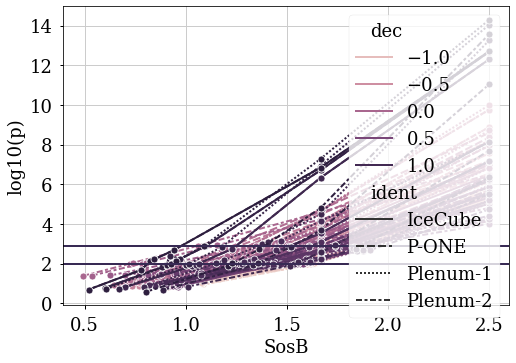

In [44]:
xname = "SosB" # "n_sig" # "scaler" # "SosB" # 
df = pd.read_pickle("../resources/txs_spectral_disc_pot.pickle")
thresholds = [sigma3, 0.01]
ax = sns.lineplot(data=df, y="log10(p)", x=xname, hue="dec", marker="o", style="ident")
#ax.legend([])
for t in thresholds:
    plt.axhline(-np.log10(t))


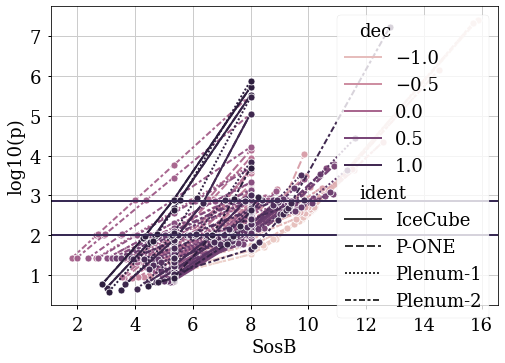

In [45]:
xname = "SosB" # "n_sig" # "scaler" # "SosB" # 
df = pd.read_pickle("../resources/txs_spectral_disc_pot_reduced_bg.pickle")
thresholds = [sigma3, 0.01]
ax = sns.lineplot(data=df, y="log10(p)", x=xname, hue="dec", marker="o", style="ident")
#ax.legend([])
for t in thresholds:
    plt.axhline(-np.log10(t))


### plot thresholds

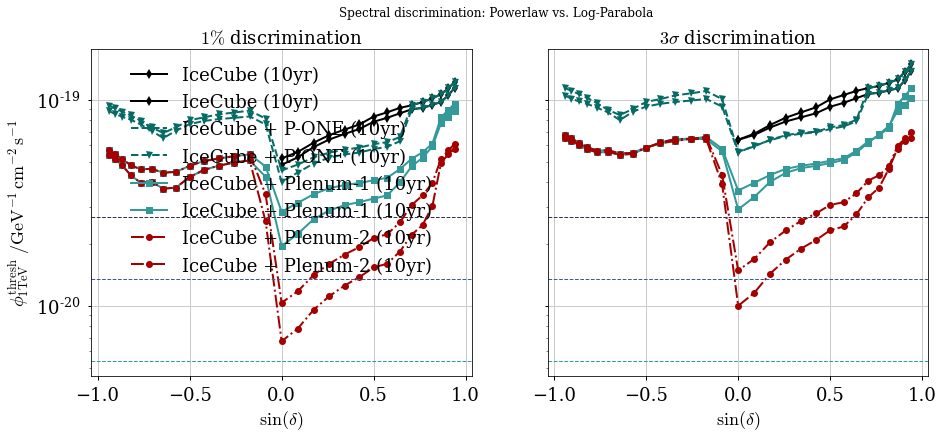

In [46]:
#
df = pd.read_pickle("../resources/txs_spectral_disc_pot.pickle")
flux = pd.DataFrame(
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma3)) * txs_para_flux.norm,
    columns=["sigma3"],
)
flux["1%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.01)) * txs_para_flux.norm
)
flux = flux.reset_index()
flux["bg"] = "full"

df = pd.read_pickle("../resources/txs_spectral_disc_pot_reduced_bg.pickle")
tmp = pd.DataFrame(
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma3)) * txs_para_flux.norm,
    columns=["sigma3"],
)
tmp["1%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.01)) * txs_para_flux.norm
)
tmp = tmp.reset_index()
tmp["bg"] = "reduced"

flux = pd.concat([flux, tmp])

f, axes = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)
for (ident, bg), series in flux.groupby(["ident", "bg"]):
    axes[1].plot(
        np.sin(series.dec),
        series.sigma3,
        **{k: poles[ident][k] for k in ["marker", "color", "ls"]}
    )
    axes[0].plot(
        np.sin(series.dec),
        series["1%"],
        **{k: poles[ident][k] for k in ["marker", "color", "label", "ls"]}
    )
for ax in axes:
    ax.set_yscale("log")
    for i,c in zip([1, 2, 5], colorlist):
        ax.axhline(PHI_TXS / i, ls="--", lw=1, color=c)
    ax.set_xlabel(r"$\sin(\delta)$")
    #ax.set_ylim(0.5e-14, 2.5e-13)
axes[0].legend(loc="upper center", frameon=False)
axes[0].set_title(r"$1\%$ discrimination")
axes[1].set_title(r"$3 \sigma$ discrimination")
axes[0].set_ylabel(
    r"$\phi^{\mathrm{thresh}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
f.suptitle(r"Spectral discrimination: Powerlaw vs. Log-Parabola")
f.savefig("../plots/txs_spectral_disc_pot.pdf", bbox_inches="tight")


# TXS: Varying livetime

IDEA: keep number of event fixed for different time window sizes
-> Vary LIVETIME of background

In [47]:
pvals_txs = []
ident = ["IceCube", "Plenum-1", "Plenum-2"]
lt= [10, 50, 100, 200, 500]
fact = [0.1, 0.25, 0.5, 1, 2]
txs_bg_config = copy(txs_src_config)

for (identifier, livetime, scaler) in product(ident, lt, fact):
    if livetime != "full":
        txs_bg_config["livetime"] = livetime * 24 * 3600
    else:
        txs_bg_config["livetime"] = LIVETIME
    aeff_factor_bckg = calc_aeff_factor(
            aeff_2d[identifier], dpsi_max=delta_psi_max, **txs_bg_config
        )
    aeff_factor_signal = calc_aeff_factor(
            aeff_2d[identifier], dpsi_max=0, **txs_src_config
        )

    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(txs0506.dec.rad, spl_vals, sindec_mids),
        normed_kvals=improved_nkv,
    )
    k_s = astro_flux(
            aeff_factor_signal,
            emids,
            improved_nkv,
            scaler,
            txs_flux,
        )
    k_i = k_s + k_b
    dct = dict(
        mu_b_base=aeff_factor_bckg,
        mu_s_base=aeff_factor_signal,
        k_i=k_i,
        e_0=txs_flux.E0,
        phi_0=txs_flux.norm,
        normed_kvals=improved_nkv,
        src_dec=txs_src_config["dec"],
    )
    local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 2), shape="powerlaw", **dct)
    global_llh = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1.2, 0, 2),
        approx_grad=True,
    )

    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1., scaler, 2),
        approx_grad=True,
    )

    # check the LLH at the "correct" parameter position
    check = global_llh((1, 1, txs_flux.gamma))
    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    pval_check = chi2.sf(out_bckg[1] - check, 1)
    significance = norm.isf(pval)
    pvals_txs.append(
        {
            "identifier": identifier,
            "livetime": txs_bg_config["livetime"] / 24 / 3600,
            "scaler": scaler, 
            "pval": pval,
            r"sigma": significance,
            "n_ev": np.round(np.sum(k_s), 3)
        }
    )


In [48]:
pval_df = pd.DataFrame(pvals_txs)
pval_df.loc[pval_df.sigma > 7, "sigma"] = 7
pval_df["log10(p)"] = -np.log10(pval_df["pval"])

### nice plots

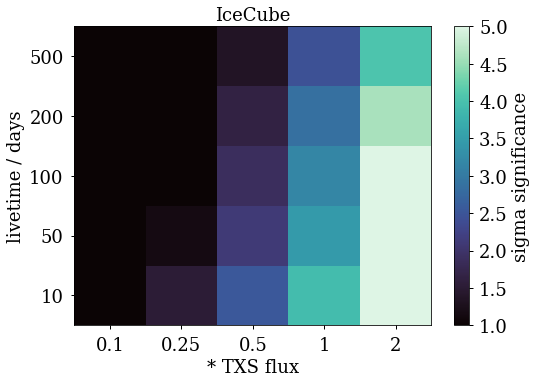

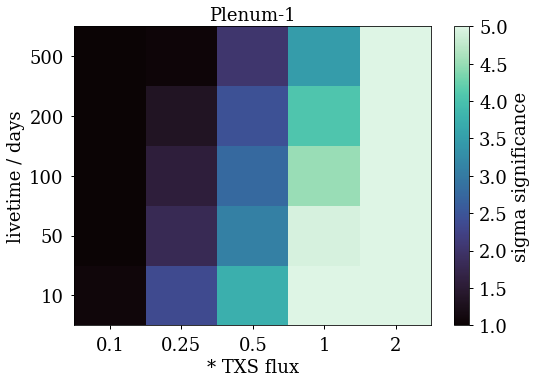

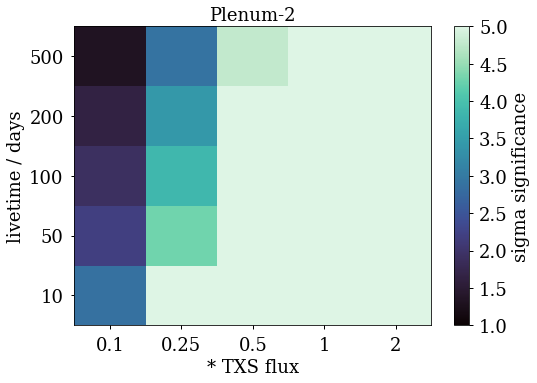

In [49]:
for idt in ident:
    mask = pval_df.identifier ==  idt

    f, ax = plt.subplots()
    im = ax.pcolormesh(pd.pivot_table(data=pval_df.loc[mask], index="livetime", columns="scaler", values="sigma"), vmin=1, vmax=5)
    cb = plt.colorbar(im)
    cb.set_label("sigma significance")
    #cb.set_label("-log10(pval)")
    ax.set_yticks(np.arange(len(lt)) + 0.5, minor=False)
    ax.set_xticks(np.arange(len(fact)) + 0.5, minor=False)
    ax.set_yticklabels(lt)
    ax.set_xticklabels(fact)

    ax.set_ylabel("livetime / days")
    ax.set_xlabel("* TXS flux")

    ax.set_title(idt)
    f.savefig(f"../plots/txs_flare_2D_significance_{idt}.pdf", bbox_inches="tight")


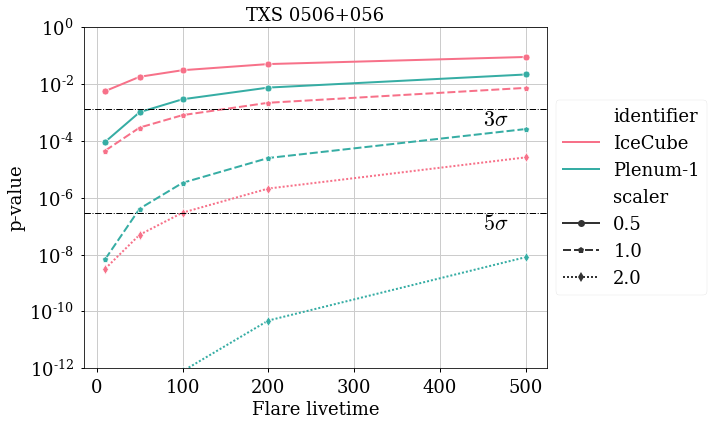

In [50]:
f, ax = plt.subplots(figsize=(10, 6))
label_size = "x-small"
sns.lineplot(
    data=pval_df.loc[(pval_df.identifier != "Plenum-2") & (pval_df.scaler > 0.3)],
    x="livetime",
    y="pval",
    hue="identifier",
    style="scaler",
    markers=["o", "p", "d"],  # , "v", "s"],
    sizes=150,
    palette="husl",
)

ax.set_ylim(1e-12, 1)
ax.set_yscale("log")
ax.axhline(1 - norm.cdf(5), lw=1, color="k", ls="-.")
ax.text(
    pval_df.livetime.max() * 0.9,
    1 - norm.cdf(5),
    r"$5 \sigma$",
    color="k",
    va="top",
    fontsize=22,
)
ax.axhline(1 - norm.cdf(3), lw=1, color="k", ls="-.")
ax.text(
    pval_df.livetime.max() * 0.9,
    1 - norm.cdf(3),
    r"$3 \sigma$",
    color="k",
    va="top",
    fontsize=22,
)

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))  # fontsize="x-small")
ax.set_title("TXS 0506+056")  # , fontsize="small")
ax.set_xlabel("Flare livetime")
ax.set_ylabel(r"p-value")
# ax.set_ylabel(r"Significance in $\sigma$")
f.tight_layout()
f.savefig("../plots/powerlaw_sigma_vs_livetime_txs.pdf")


## Discovery potential

In [60]:
tmp = []
decs = [-30, 0, 30]
ident = ["IceCube", "Plenum-1", "Plenum-2"]
lt = [10, 50, 100, 300]
thresholds = [sigma5]

for (identifier, livetime, dec) in tqdm(product(ident, lt, np.deg2rad(decs))):

    if identifier == "IceCube" and dec <= np.deg2rad(-5):
        # skip the Southern Hemisphere
        continue

    src_config["dec"] = dec
    bg_config = copy(src_config)

    if livetime != "full":
        bg_config["livetime"] = livetime * 24 * 3600
    else:
        bg_config["livetime"] = LIVETIME
    aeff_factor_bckg = calc_aeff_factor(
        aeff_2d[identifier], dpsi_max=delta_psi_max, **bg_config
    )
    aeff_factor_signal = calc_aeff_factor(aeff_2d[identifier], dpsi_max=0, **src_config)

    # asimov data
    k_b_ref = atmo_background(
        aeff_factor_bckg,
        array_source_interp(src_config["dec"], spl_vals, sindec_mids),
        normed_kvals=improved_nkv,
    )
    k_s_ref = astro_flux(
        aeff_factor_signal,
        emids,
        improved_nkv,
        1,
        txs_flux,
    )
    # calculate an estimate for the flux scaling
    # based on n_sig
    scaler = 15 / np.sum(k_s_ref)
    current_thresholds = copy(thresholds)

    while len(current_thresholds) > 0:
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            improved_nkv,
            scaler,
            txs_flux,
        )
        k_i = k_s + k_b_ref

        dct = dict(
            mu_b_base=aeff_factor_bckg,
            mu_s_base=aeff_factor_signal,
            k_i=k_i,
            e_0=txs_flux.E0,
            phi_0=txs_flux.norm,
            normed_kvals=improved_nkv,
            src_dec=dec,
        )
        # fix signal contribution to 0
        local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 2), shape="powerlaw", **dct)
        global_llh = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2,),
            approx_grad=True,
        )

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, scaler, 2.1),
            approx_grad=True,
        )
        tmp_dct = {
            "ident": identifier,
            "dec": dec,
            "scaler": scaler,
            "livetime": livetime,
            "cur_thresh": current_thresholds[0],
            "SosB": np.sum(k_s) / np.sqrt(np.sum(k_b_ref)),
            "n_b": np.sum(k_b_ref),
            "n_sig": np.sum(k_s),
            "out_bckg": out_bckg,
            "out_comp": out_comp,
            "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2)),
        }
        tmp.append(tmp_dct)
        tmp_df = pd.DataFrame(tmp)

        mask = (
            (tmp_df.dec == dec)
            & (tmp_df.ident == identifier)
            & (tmp_df.livetime == livetime)
            & (tmp_df.cur_thresh == current_thresholds[0])
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask],
            current_thresholds,
            scaler,
            stop_here=0.2,
            stepper=2,
            min_steps=1,
        )

        if scaler == -1:
            break

df = pd.DataFrame(tmp)
df.to_pickle("../resources/txs_time_disc_pot.pickle")


36it [00:13,  2.68it/s]


In [61]:
# df = pd.read_pickle("../resources/txs_time_disc_pot.pickle")

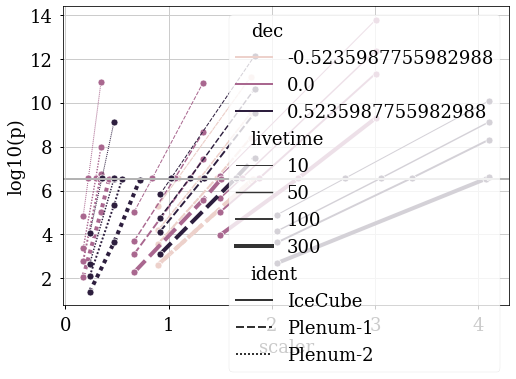

In [64]:
ax = sns.lineplot(
    data=df, y="log10(p)", x="scaler", hue="dec", marker="o", size="livetime", style="ident"
)
for t in thresholds:
    plt.axhline(-np.log10(t))

### plotting

In [54]:
from settings import many_colors
sns.set_palette(many_colors)


In [55]:
flux = pd.DataFrame(
    df.groupby(["ident", "dec", "livetime"]).apply(lambda x: get_scaler(x, sigma5))
    * txs_flux.norm,
    columns=["disc5"],
).reset_index()


In [56]:
linestyles = ["-", "--", "-.", ":"]

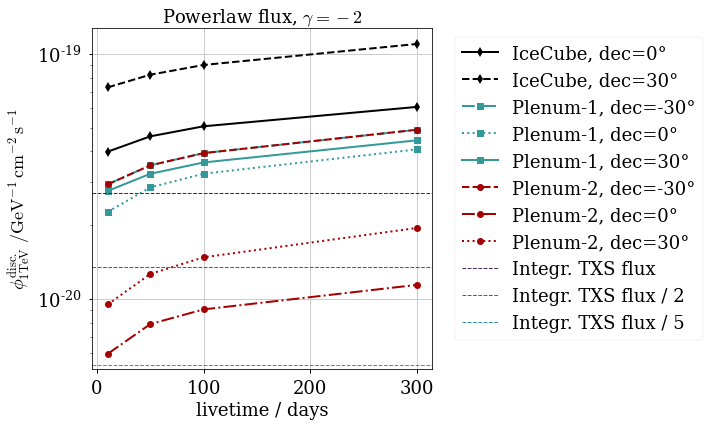

In [57]:
f, ax = plt.subplots(figsize=(10,6))
for i, ((ident, dec), series) in enumerate(flux.groupby(["ident", "dec"])):
    plt.plot(
        series.livetime,
        series.disc5,
        label=f"{ident}, dec={np.rad2deg(dec):1.0f}°",
        ls=linestyles[i%4],
        **{k: poles[ident][k] for k in ["marker", "color"]}
    )
ax.set_yscale("log")
ax.axhline(PHI_TXS, ls="--", lw=1, color=colorlist[0], label="Integr. TXS flux")
ax.axhline(PHI_TXS / 2, ls="--", lw=1, color=colorlist[1], label="Integr. TXS flux / 2")
ax.axhline(PHI_TXS / 5, ls="--", lw=1, color=colorlist[2], label="Integr. TXS flux / 5")

ax.set_xlabel(r"livetime / days")
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
ax.legend(loc="upper left", bbox_to_anchor=(1.04,1)) #, fontsize="medium")
ax.set_title(r"Powerlaw flux, $\gamma=-2$")
#ax.set_xlim(0, 110)
f.tight_layout()
#ax.set_ylim(0.5e-14, 1e-13)
#f.savefig("../plots/txs_disc_pot.pdf", bbox_inches="tight")
